In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load and preprocess data
data = pd.read_csv('bank-full.csv', delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## EDA

In [14]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000



Target Variable Distribution:


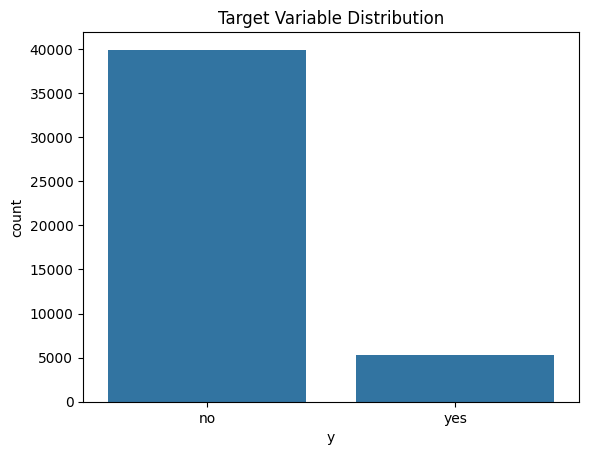

In [15]:
print("\nTarget Variable Distribution:")
sns.countplot(x='y', data=data)
plt.title('Target Variable Distribution')
plt.show()


Correlation Heatmap:


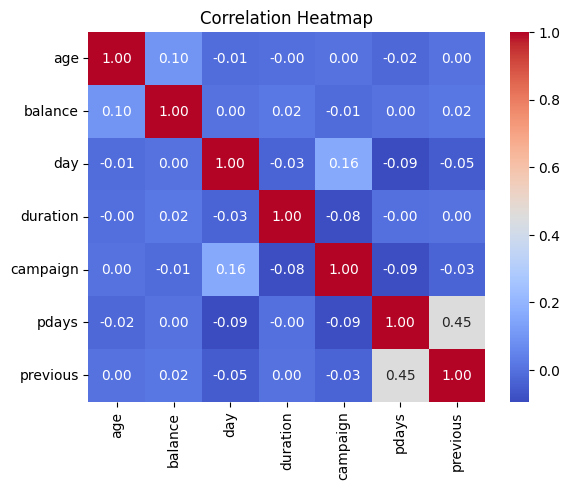

In [16]:
print("\nCorrelation Heatmap:")
corr = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Bidirectional RNN

In [17]:
# Preprocessing
def preprocess_data(data):
    X = data.drop('y', axis=1)
    X = pd.get_dummies(X)
    y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data)

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [18]:
# Define Bidirectional RNN model
class BidirectionalRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling='max'):
        super(BidirectionalRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out = torch.max(out, dim=1).values
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [19]:
# Training function
def train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader):
    best_loss = float('inf')
    patience_counter = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item()
                predictions = torch.round(torch.sigmoid(outputs.squeeze()))
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)
        test_loss /= len(test_loader)
        accuracy = correct / total

        scheduler.step(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > early_stopper:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    return accuracy

In [20]:
# Experiment configurations
hidden_sizes = [16, 32, 64]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper = 10

# Run experiments for Bidirectional RNN and save results
results = []
for hidden_size in hidden_sizes:
    for pooling in poolings:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print("=====================================================================")
                print(f"\nConfiguration: Bidirectional RNN Hidden Size={hidden_size}, Pooling={pooling}, Optimizer={optimizer_name}, Epochs={num_epochs}")
                model = BidirectionalRNNModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=1, output_size=1, pooling=pooling)
                criterion = nn.BCEWithLogitsLoss()

                if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.01)

                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
                accuracy = train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader)

                results.append({
                    'Model Type': 'Bidirectional RNN',
                    'Hidden Size': hidden_size,
                    'Pooling': pooling,
                    'Optimizer': optimizer_name,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy
                })
results_df = pd.DataFrame(results)
results_df.to_csv('Experiment_Bidirectional_RNN_results.csv', index=False)



Configuration: Bidirectional RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 0.4203, Test Loss: 0.3227, Accuracy: 0.8821
Epoch 2/5, Train Loss: 0.2871, Test Loss: 0.2715, Accuracy: 0.8902
Epoch 3/5, Train Loss: 0.2541, Test Loss: 0.2525, Accuracy: 0.8972
Epoch 4/5, Train Loss: 0.2408, Test Loss: 0.2448, Accuracy: 0.8986
Epoch 5/5, Train Loss: 0.2351, Test Loss: 0.2415, Accuracy: 0.9014

Configuration: Bidirectional RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 0.4048, Test Loss: 0.2989, Accuracy: 0.8904
Epoch 2/50, Train Loss: 0.2706, Test Loss: 0.2608, Accuracy: 0.8963
Epoch 3/50, Train Loss: 0.2489, Test Loss: 0.2491, Accuracy: 0.8962
Epoch 4/50, Train Loss: 0.2410, Test Loss: 0.2448, Accuracy: 0.8986
Epoch 5/50, Train Loss: 0.2372, Test Loss: 0.2430, Accuracy: 0.8997
Epoch 6/50, Train Loss: 0.2353, Test Loss: 0.2420, Accuracy: 0.9007
Epoch 7/50, Train Loss: 0.2345, Test Loss: 0.2413, Accuracy: 0.9007
Epoch 8/50, Tr

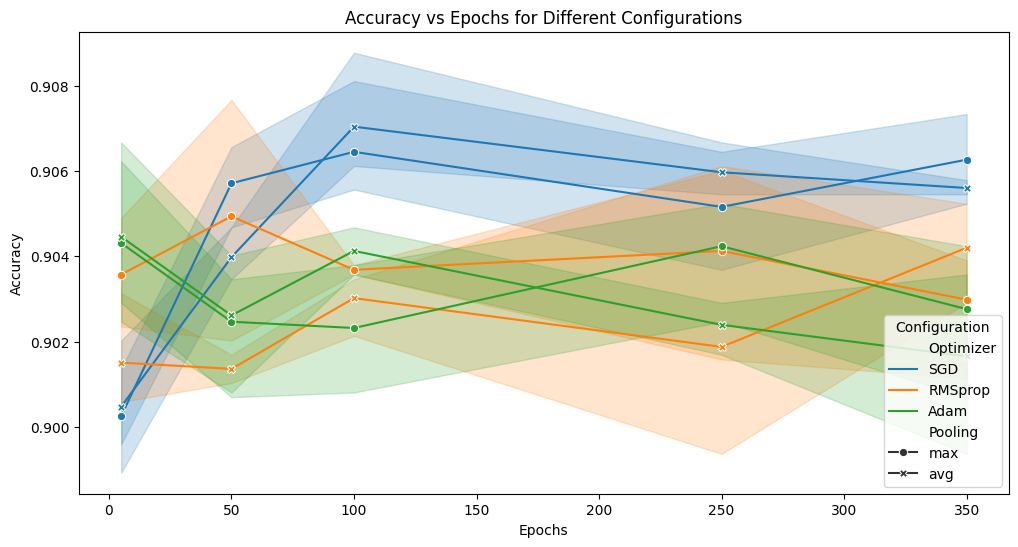

In [21]:
def visualize_results(results_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=results_df, x='Epochs', y='Accuracy', hue='Optimizer', style='Pooling', markers=True, dashes=False)
    plt.title('Accuracy vs Epochs for Different Configurations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(title='Configuration', loc='lower right')
    plt.show()

visualize_results(results_df)


In [22]:
 # Display top 10 as table
from tabulate import tabulate
top_10 = results_df.sort_values(by='Accuracy', ascending=False).head(10)
print("Top 10 Results:")
print(tabulate(top_10, headers='keys', tablefmt='pretty', showindex=False))


Top 10 Results:
+-------------------+-------------+---------+-----------+--------+--------------------+
|    Model Type     | Hidden Size | Pooling | Optimizer | Epochs |      Accuracy      |
+-------------------+-------------+---------+-----------+--------+--------------------+
| Bidirectional RNN |     64      |   avg   |    SGD    |  100   | 0.9087692137564968 |
| Bidirectional RNN |     16      |   max   |    SGD    |  100   | 0.9081057171292712 |
| Bidirectional RNN |     32      |   max   |  RMSprop  |   50   | 0.9076633860444543 |
| Bidirectional RNN |     64      |   max   |    SGD    |  350   | 0.9073316377308416 |
| Bidirectional RNN |     64      |   avg   |    SGD    |  250   | 0.906668141103616  |
| Bidirectional RNN |     64      |   avg   |   Adam    |   5    | 0.906668141103616  |
| Bidirectional RNN |     32      |   max   |    SGD    |   50   | 0.9065575583324118 |
| Bidirectional RNN |     64      |   max   |    SGD    |  250   | 0.9064469755612076 |
| Bidirectional 